In [2]:
from unet import UNet
from train import LineSegmentationDataset
from pathlib import Path
import sys
sys.path.append("..")

run_name = "20250507_121716_run_saved"
experiment_folder = Path("./runs") / run_name
model = UNet.load(experiment_folder)
model = model.to("cuda")

In [3]:
# define where to save
save_folder = Path("./saved_models") / run_name
save_folder.mkdir(parents=True, exist_ok=True)

# if UNet has a save helper
model.save(save_folder)
print(f"UNet saved to {save_folder}")

UNet saved to saved_models/20250507_121716_run_saved


In [4]:
from synthetic import DataGenerator, SynthSettings

gen_settings = SynthSettings(
    downscale_factor=0.5,
    cutout_noise=True,
    cutout_noise_size=200,
    warp_noise=True,
    warp_noise_strength=5
)
generator = DataGenerator(settings=gen_settings)
_, _, scrolls, lines = generator.generate_passages_scrolls(70)

In [5]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

def inference(scrolls, lines = None):

    track_loss = lines is not None

    if not track_loss:
        lines = np.empty((scrolls.shape[0], 0))

    data = LineSegmentationDataset(scrolls, lines)
    criterion = nn.BCEWithLogitsLoss()
    hats = []
    model.eval()
    test_loss = []
    with torch.no_grad():
        for batch_scrolls, batch_lines in DataLoader(data):
            batch_scrolls, batch_lines = batch_scrolls.to("cuda"), batch_lines.to("cuda")
            lines_hat = model(batch_scrolls)
            out = F.sigmoid(lines_hat)
            hats.append(out.cpu().numpy())

            if track_loss:
                loss = criterion(lines_hat, batch_lines)
                test_loss.append(loss.item())


    hats = np.concatenate(hats)
    if track_loss:
        return hats, np.mean(test_loss)
    else:
        hats


hats, loss = inference(scrolls, lines)
loss

np.float64(0.09454362967184611)

In [6]:
def get_quantile_2d(raw_mask: np.ndarray, q: float = 0.62) -> np.ndarray:
    """
    raw_mask shape (H,W)
    """
    threshold_value = np.quantile(raw_mask, q)
    mask = (raw_mask >= threshold_value).astype(np.uint8)
    return mask


In [7]:
from matplotlib import pyplot as plt
inds = np.random.choice(scrolls.shape[0], size=3, replace=False)

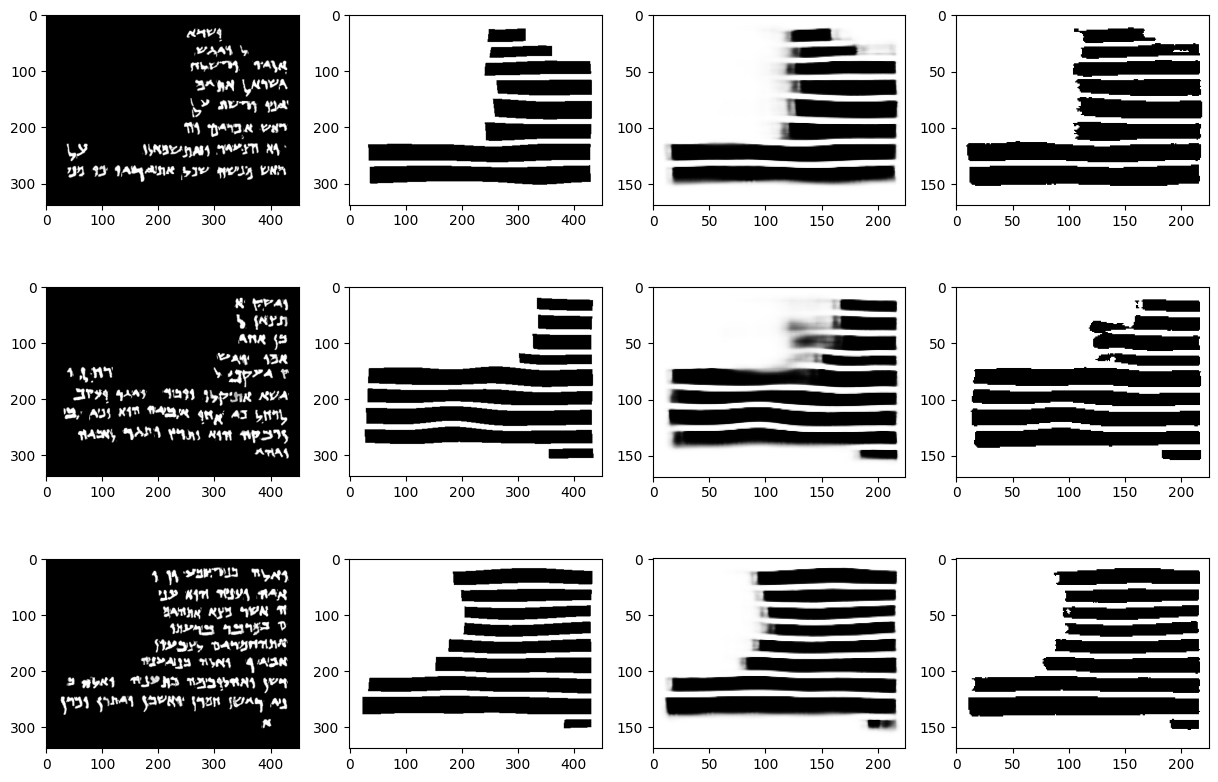

In [8]:

fig, ax = plt.subplots(3, 4, figsize=(15,10))
for i, index in enumerate(inds):
    ax[i, 0].imshow(scrolls[index], cmap="binary")
    ax[i, 1].imshow(lines[index], cmap="binary")
    ax[i, 2].imshow(np.squeeze(hats[index]), cmap="binary")
    ax[i, 3].imshow(get_quantile_2d(np.squeeze(hats[index])), cmap="binary")

plt.show()

In [9]:
from synthetic import extract_lines_cc
import cv2

def resize_image(image_to_resize, reference_image_for_shape):
    print(f"To resize shape: {image_to_resize.shape}, Target: {reference_image_for_shape.shape}")
    target_height, target_width = reference_image_for_shape.shape[:2]
    resized_image = cv2.resize(
        image_to_resize,
        (target_width, target_height),
        interpolation=cv2.INTER_LINEAR # Use cv2.INTER_NEAREST for masks if preferred
    )
    print(f"Resized: {resized_image.shape}, Target: {reference_image_for_shape.shape}")
    return resized_image

image_to_resize = hats[0].squeeze()
reference_image_for_shape = scrolls[0]

resized = resize_image(image_to_resize,reference_image_for_shape)
resized.shape

To resize shape: (169, 225), Target: (338, 451)
Resized: (338, 451), Target: (338, 451)


(338, 451)

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt # For debugging visualizations

def extract_lines_cc_tuned(
    img: np.ndarray,
    raw_prediction_mask: np.ndarray, # Expects raw model output (e.g., probabilities)
    binarization_threshold: float = 0.5, # Threshold to convert raw prediction to binary
    min_area_on_mask: int = 100, # Min area of a component on the (possibly low-res) prediction mask
    # max_area_on_mask_ratio: float = 0.9, # Max area of a component on mask, as ratio of mask's total area
    inflate_pixels: int = 6
) -> list[np.ndarray]:

    # 2. Binarize the raw prediction mask using the specified threshold
    mask8 = (raw_prediction_mask > binarization_threshold).astype(np.uint8) * 255
    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        mask8, connectivity=8
    )

    h_mask, w_mask = mask8.shape # Dimensions of the binarized low-res mask
    h_img, w_img = img.shape[:2]  # Dimensions of the high-res original image

    scale_y = h_img / h_mask
    scale_x = w_img / w_mask

    extracted_lines = []
    # Label 0 is the background, so iterate from 1
    for lab in range(1, n_labels):
        x_m, y_m, bw_m, bh_m, area_m = stats[lab]
        # Bounding box coordinates in the mask's space (low-res)
        x0_m = x_m
        y0_m = y_m
        x1_m = x_m + bw_m
        y1_m = y_m + bh_m

        # Scale coordinates to the original image's space (high-res)
        x0_img = int(x0_m * scale_x)
        y0_img = int(y0_m * scale_y)
        x1_img = int(x1_m * scale_x)
        y1_img = int(y1_m * scale_y)

        # Apply inflation in the image coordinate space
        crop_x0 = max(x0_img - inflate_pixels, 0)
        crop_y0 = max(y0_img - inflate_pixels, 0)
        crop_x1 = min(x1_img + inflate_pixels, w_img)
        crop_y1 = min(y1_img + inflate_pixels, h_img)
        crop = img[crop_y0:crop_y1, crop_x0:crop_x1].copy()
        extracted_lines.append(crop)
       
    return extracted_lines

To resize shape: (169, 225), Target: (338, 451)
Resized: (338, 451), Target: (338, 451)
8
8


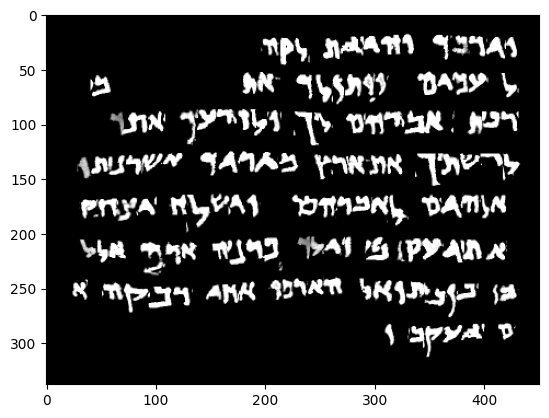

In [11]:
inds = 3
plt.imshow(scrolls[3], cmap="binary")
extracted_prediction = extract_lines_cc_tuned(scrolls[inds], resize_image(hats[inds].squeeze(), scrolls[inds]))
extracted_label = extract_lines_cc_tuned(scrolls[inds], lines[inds])
print(len(extracted_prediction))
print(len(extracted_label))



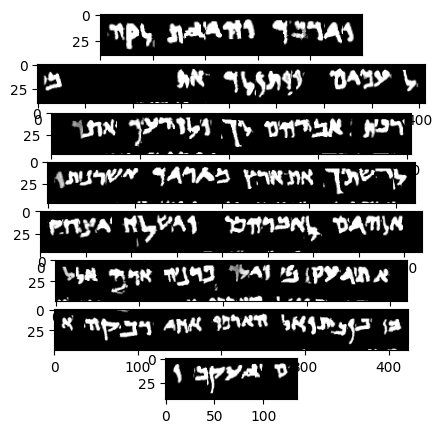

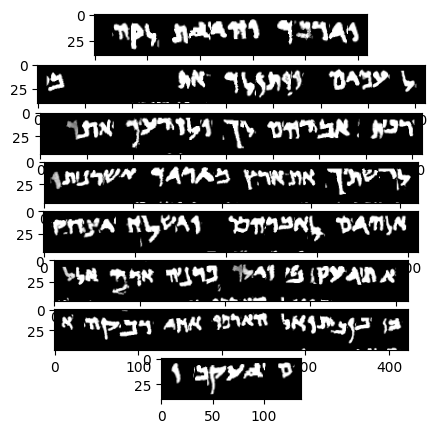

In [12]:
fig, ax = plt.subplots(len(extracted_label),1, figsize=(5,5))
for i, index in enumerate(extracted_label):
    ax[i].imshow(index, cmap="binary")
fig, ax = plt.subplots(len(extracted_prediction),1, figsize=(5,5))
for i, index in enumerate(extracted_prediction):
    ax[i].imshow(index, cmap="binary")

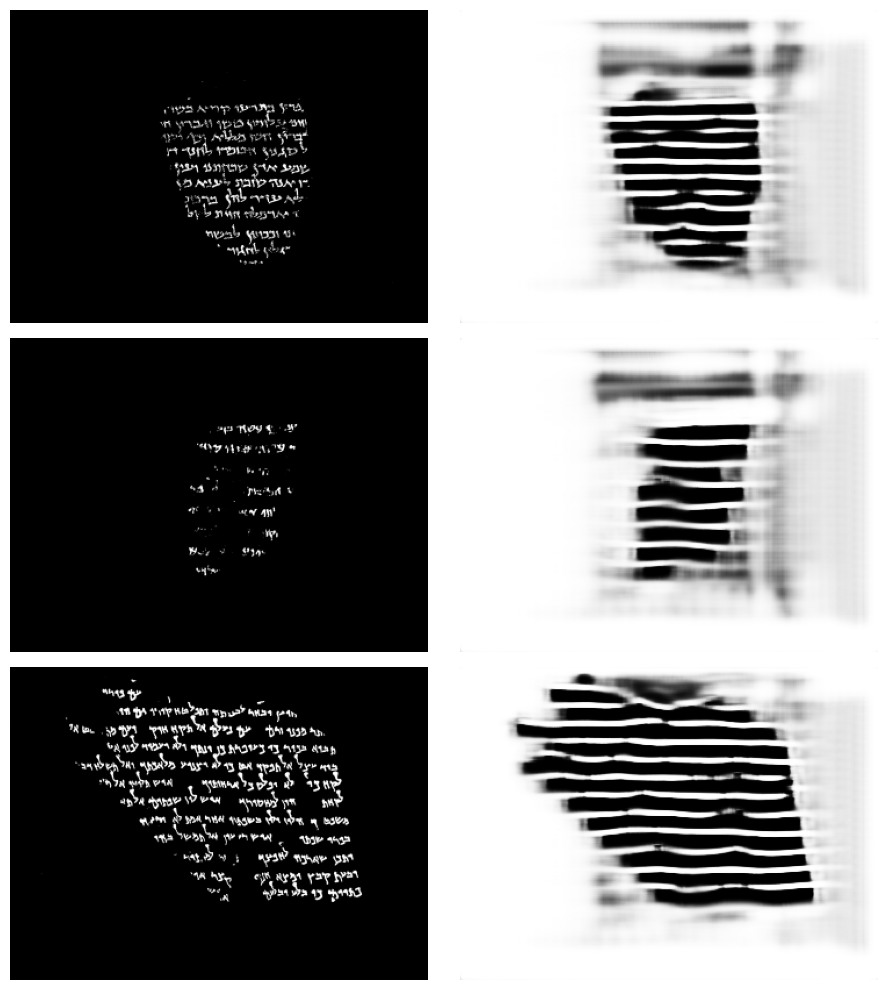

In [13]:
from pathlib import Path
from PIL import Image

test_data_path = Path(".").resolve().parent / "data" / "image-data"

test_imgs = []

def resize(img: np.ndarray, factor: float):

    height, width = img.shape
    nh = int(height * factor)
    nw = int(width * factor)

    ri = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)

    return ri

for ent in test_data_path.iterdir():

    if ent.is_dir() or not ent.name.endswith("binarized.jpg"):
        continue

    img = Image.open(ent).convert("L")
    img_array = np.array(img)
    test_imgs.append(resize(img_array, factor=1)[np.newaxis, np.newaxis, :, :])

test_data_path = Path(".").resolve().parent / "data" / "image-data"

test_imgs = []

def resize(img: np.ndarray, factor: float):

    height, width = img.shape
    nh = int(height * factor)
    nw = int(width * factor)

    ri = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)

    return ri

for ent in test_data_path.iterdir():

    if ent.is_dir() or not ent.name.endswith("binarized.jpg"):
        continue

    img = Image.open(ent).convert("L")
    img_array = np.array(img)
    test_imgs.append(resize(img_array, factor=0.1)[np.newaxis, np.newaxis, :, :])

test_hats = []
for img in test_imgs:

    img = torch.tensor(img, dtype=torch.float, device="cuda")
    img = 1 - (img / 255)

    with torch.no_grad():
        test_hat = model(img)
        out = F.sigmoid(test_hat)
        test_hats.append(out.squeeze().cpu().numpy())

fig, ax = plt.subplots(3, 2, figsize=(10, 10))

inds = np.random.choice(len(test_imgs), size=3, replace=False)

for i, index in enumerate(inds):
    ax[i, 0].imshow(test_imgs[index].squeeze(), cmap="binary")
    ax[i, 1].imshow(test_hats[index].squeeze(), cmap="binary")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()



fig.tight_layout()
fig.tight_layout()
plt.show()

In [31]:
image = test_hats[0]


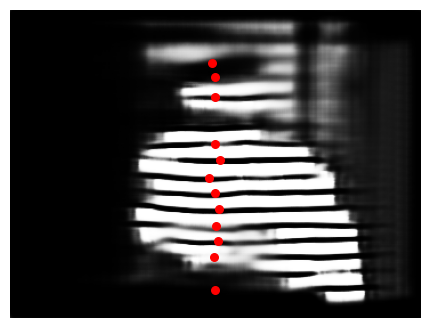

Detected centers (x, y):
(176.25730994152048, 46.0)
(179.5, 58.0)
(179.5, 76.0)
(179.5, 117.0)
(183.56716417910448, 131.0)
(173.64601769911505, 147.0)
(179.5, 160.0)
(182.38372093023256, 174.0)
(180.42857142857142, 189.0)
(181.89644970414201, 202.0)
(178.63513513513513, 216.0)
(179.5, 245.0)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

thresh = 0.5
mask = image < thresh          # boolean mask of dark pixels

proj = mask.sum(axis=1)      # for each row, count dark pixels

kernel = np.ones(7) / 7
proj_smooth = np.convolve(proj, kernel, mode='same')

peak_idxs = np.where(
    (proj_smooth[1:-1] > proj_smooth[:-2]) &
    (proj_smooth[1:-1] > proj_smooth[2:])
    )[0] + 1

min_height = proj_smooth.max() * 0.2
ys = [y for y in peak_idxs if proj_smooth[y] > min_height]

centers = []
for y in ys:
    xs = np.where(mask[y])[0]
    if xs.size:
        centers.append((float(xs.mean()), float(y)))

# 6) plot
plt.figure(figsize=(6,4))
plt.imshow(image, cmap='gray')
if centers:
    xs, ys = zip(*centers)
    plt.scatter(xs, ys, c='r', s=30)
plt.axis('off')
plt.show()

print("Detected centers (x, y):")
for c in centers:
    print(c)
